In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import skimage
import math
from skimage.io import imsave, imread
from skimage.transform import resize
from PIL import Image
from shutil import copyfile
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta, Adam
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16

from keras.layers import BatchNormalization
from keras.optimizers import RMSprop

from keras.utils import np_utils

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.svm import SVC

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ImportError: Could not find 'cudart64_90.dll'. TensorFlow requires that this DLL be installed in a directory that is named in your %PATH% environment variable. Download and install CUDA 9.0 from this URL: https://developer.nvidia.com/cuda-toolkit

In [2]:
from preprocess import load_dir, preprocess_and_save_images, divide_to_train_end_test

In [3]:
from work_with_keras_nets import shuffle_Xy, create_net_with_name, one_hot, plot_confusion_matrix

In [4]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [5]:
# fix random seed for reproducibility
np.random.seed(42)

In [6]:
def load_dir_with_files_divided_to_5(directory, target_names):
    X_lt = []
    X_rt = []
    X_lb = []
    X_rb = []
    X_ct = []
    
    y_lt = []
    y_rt = []
    y_lb = []
    y_rb = []
    y_ct = []    
    
    for root, dirs, files in os.walk(directory):
        for name in files:
            file_path = os.path.join(root, name)
            target_name_dir_path, corner_name = os.path.split(root)
            _, target_name = os.path.split(target_name_dir_path)
            
            cur_X = imread(file_path)
            
            # сравниваем считанный target_name с названиями из target_names
            cur_y = target_names.index(target_name)
            
            if corner_name == "left_top":
                X_lt.append(cur_X)
                y_lt.append(cur_y)
            if corner_name == "right_top":
                X_rt.append(cur_X)
                y_rt.append(cur_y)
            if corner_name == "left_bottom":
                X_lb.append(cur_X)
                y_lb.append(cur_y)
            if corner_name == "right_bottom":
                X_rb.append(cur_X)
                y_rb.append(cur_y)
            if corner_name == "center":
                X_ct.append(cur_X)
                y_ct.append(cur_y)
                
    return np.array(X_lt), np.array(y_lt), np.array(X_rt), np.array(y_rt), np.array(X_lb), np.array(y_lb), \
np.array(X_rb), np.array(y_rb), np.array(X_ct), np.array(y_ct)
    

In [7]:
%%time
X_lt_FNML128, y_lt_FNML128, X_rt_FNML128, y_rt_FNML128, X_lb_FNML128, y_lb_FNML128, X_rb_FNML128, y_rb_FNML128, X_ct_FNML128, y_ct_FNML128 \
= load_dir_with_files_divided_to_5("D:/svruchtel/PREPROCESSED_DATA/France_New_ByMeaningLarge_128_3dim",
                                ["AllTransport", "Restaurant"])

Wall time: 46.9 s


In [8]:
def print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count):
    ### CONFUSION MATRIX 
    
    y_pred_train = model.predict(X_train)
    cnf_matrix = confusion_matrix(one_hot(y_train, categories_count).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

    y_pred_test = model.predict(X_test)
    cnf_matrix = confusion_matrix(one_hot(y_test, categories_count).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

In [9]:
### VGG16, without retrain

def run_VGG16_without_retrain_on_dataset(X_train, y_train, X_test, y_test, categories_count, patience):
    
    model_app = VGG16(input_shape=X_train[0].shape, include_top=False)
    model_app.trainable = False
    
    model = Sequential()
    model.add(model_app)
    model.add(Flatten())
    #model.add(Dropout(0.4))
    #model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(categories_count, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    history_callback = model.fit(X_train, one_hot(y_train, categories_count), 
                                 validation_data=(X_test, one_hot(y_test, categories_count)),
                                 epochs=300, batch_size=10, callbacks=[callback])

    test_scores = model.evaluate(X_test, one_hot(y_test, categories_count), verbose=0)
    
    print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count)
    
    return model, history_callback, test_scores

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 16386     
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 19s 6ms/step - loss: 6.7440 - acc: 0.5808 - val_loss: 6.7482 - val_acc: 0.5813
Epoch 2/300
2977/2977 [==============================] - 15s 5ms/step

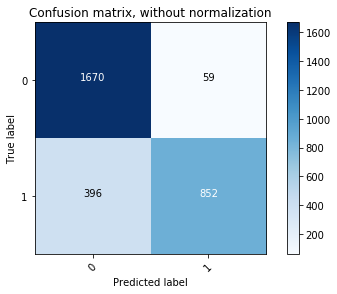

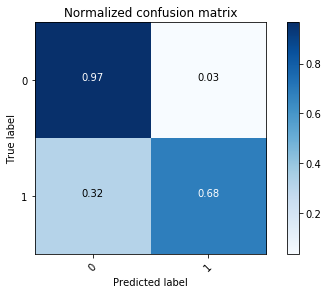

Confusion matrix, without normalization
[[178  15]
 [ 51  88]]
Normalized confusion matrix
[[0.92227979 0.07772021]
 [0.36690647 0.63309353]]


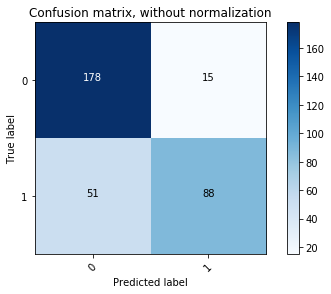

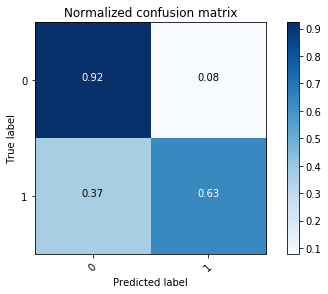

Wall time: 3min 12s


In [10]:
%%time
X_ct_train, y_ct_train, X_ct_test, y_ct_test = divide_to_train_end_test(X_ct_FNML128, y_ct_FNML128, num_categories=2)


model_ct, history_ct, test_scores_ct = run_VGG16_without_retrain_on_dataset(X_ct_train, y_ct_train,
                                                                           X_ct_test, y_ct_test,
                                                                           categories_count=2,
                                                                           patience=7)

In [11]:
print("center result accuracy:", test_scores_ct[1])

center result accuracy: 0.8012048185589802


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 16386     
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 15s 5ms/step - loss: 3.5170 - acc: 0.7172 - val_loss: 1.8704 - val_acc: 0.8434
Epoch 2/300
2977/2977 [==============================] - 15s 5ms/step

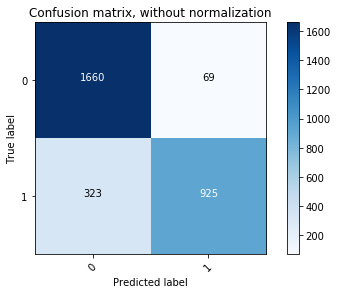

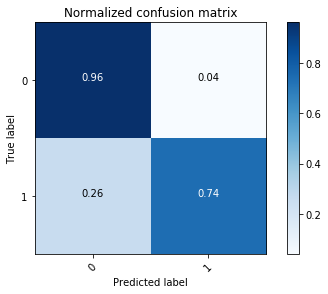

Confusion matrix, without normalization
[[182  11]
 [ 45  94]]
Normalized confusion matrix
[[0.94300518 0.05699482]
 [0.32374101 0.67625899]]


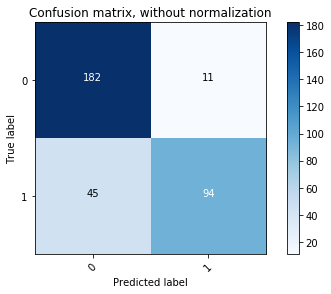

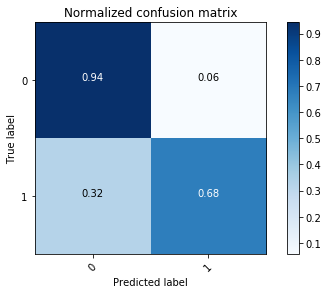

Wall time: 1min 40s


In [12]:
%%time
model_ct_1, history_ct_1, test_scores_ct_1 = run_VGG16_without_retrain_on_dataset(X_ct_train, y_ct_train,
                                                                           X_ct_test, y_ct_test,
                                                                           categories_count=2,
                                                                           patience=5)

In [13]:
print("center result accuracy:", test_scores_ct_1[1])

center result accuracy: 0.8313253019229475


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 16386     
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 15s 5ms/step - loss: 3.9122 - acc: 0.7017 - val_loss: 3.0554 - val_acc: 0.7831
Epoch 2/300
2977/2977 [==============================] - 15s 5ms/step

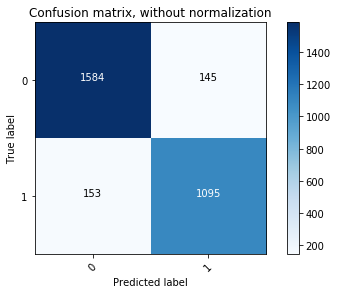

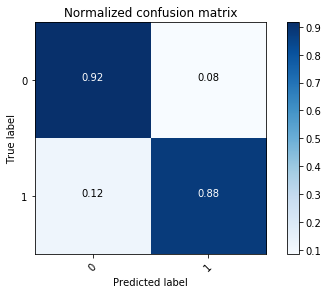

Confusion matrix, without normalization
[[161  32]
 [ 22 117]]
Normalized confusion matrix
[[0.83419689 0.16580311]
 [0.15827338 0.84172662]]


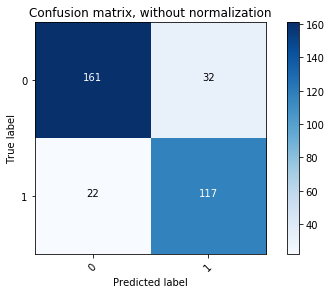

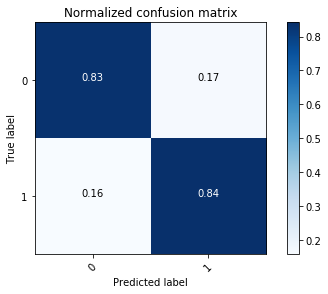

Wall time: 2min 25s


In [16]:
%%time
model_ct_2, history_ct_2, test_scores_ct_2 = run_VGG16_without_retrain_on_dataset(X_ct_train, y_ct_train,
                                                                           X_ct_test, y_ct_test,
                                                                           categories_count=2,
                                                                           patience=5)

In [17]:
print("center result accuracy:", test_scores_ct_2[1])

center result accuracy: 0.8373493975903614


In [18]:
model_ct = model_ct_2
history_ct = history_ct_2
test_scores_ct = test_scores_ct_2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 16386     
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 15s 5ms/step - loss: 4.2557 - acc: 0.6678 - val_loss: 3.6784 - val_acc: 0.7289
Epoch 2/300
2977/2977 [==============================] - 15s 5ms/step

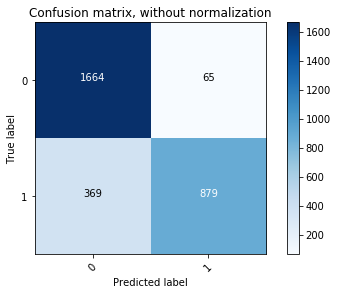

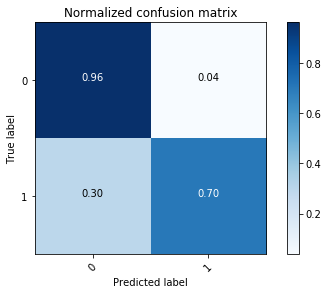

Confusion matrix, without normalization
[[184   9]
 [ 54  85]]
Normalized confusion matrix
[[0.95336788 0.04663212]
 [0.38848921 0.61151079]]


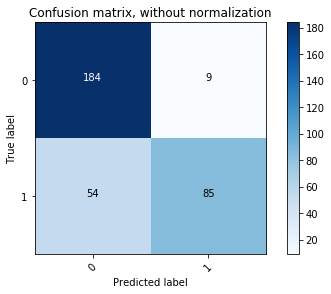

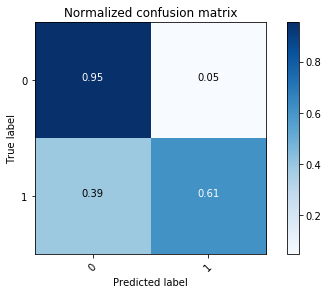

Wall time: 2min 39s


In [19]:
%%time
X_lt_train, y_lt_train, X_lt_test, y_lt_test = divide_to_train_end_test(X_lt_FNML128, y_lt_FNML128, num_categories=2)


model_lt, history_lt, test_scores_lt = run_VGG16_without_retrain_on_dataset(X_lt_train, y_lt_train,
                                                                           X_lt_test, y_lt_test,
                                                                           categories_count=2,
                                                                           patience=5)

In [20]:
print("left_top result accuracy:", test_scores_lt[1])

left_top result accuracy: 0.8102409638554217


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 16386     
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 15s 5ms/step - loss: 3.9562 - acc: 0.6842 - val_loss: 2.1977 - val_acc: 0.8193
Epoch 2/300
2977/2977 [==============================] - 15s 5ms/step

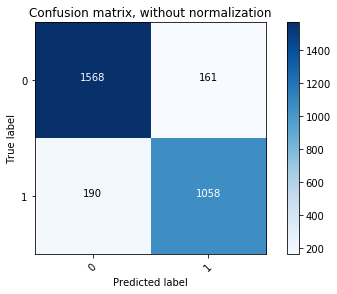

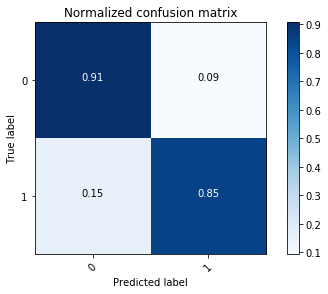

Confusion matrix, without normalization
[[187   6]
 [ 37 102]]
Normalized confusion matrix
[[0.96891192 0.03108808]
 [0.26618705 0.73381295]]


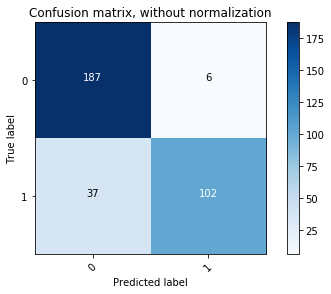

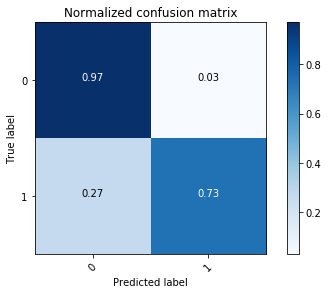

In [21]:
model_lt_1, history_lt_1, test_scores_lt_1 = run_VGG16_without_retrain_on_dataset(X_lt_train, y_lt_train,
                                                                           X_lt_test, y_lt_test,
                                                                           categories_count=2,
                                                                           patience=5)

In [22]:
print("left_top result accuracy:", test_scores_lt_1[1])

left_top result accuracy: 0.8704819269927151


In [23]:
model_lt = model_lt_1
history_lt = history_lt_1
test_scores_lt = test_scores_lt_1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 16386     
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 15s 5ms/step - loss: 4.6438 - acc: 0.6507 - val_loss: 2.2739 - val_acc: 0.8163
Epoch 2/300
2977/2977 [==============================] - 15s 5ms/step

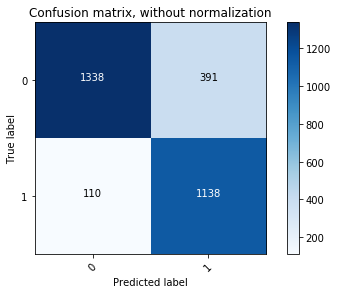

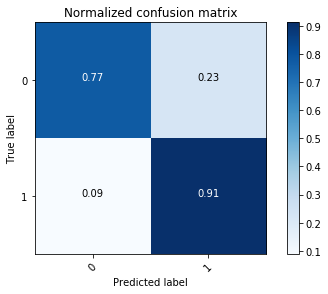

Confusion matrix, without normalization
[[155  38]
 [ 18 121]]
Normalized confusion matrix
[[0.80310881 0.19689119]
 [0.1294964  0.8705036 ]]


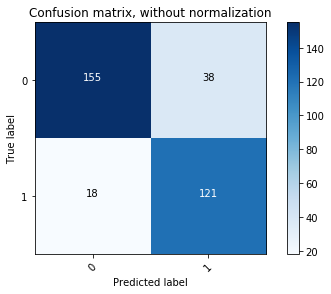

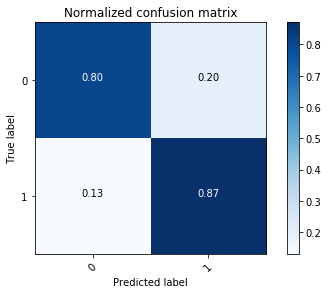

Wall time: 2min 11s


In [24]:
%%time
X_rt_train, y_rt_train, X_rt_test, y_rt_test = divide_to_train_end_test(X_rt_FNML128, y_rt_FNML128, num_categories=2)


model_rt, history_rt, test_scores_rt = run_VGG16_without_retrain_on_dataset(X_rt_train, y_rt_train,
                                                                           X_rt_test, y_rt_test,
                                                                           categories_count=2,
                                                                           patience=5)

In [25]:
print("right_top result accuracy:", test_scores_rt[1])

right_top result accuracy: 0.8313253019229475


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 16386     
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 16s 5ms/step - loss: 5.1625 - acc: 0.6298 - val_loss: 2.2226 - val_acc: 0.8313
Epoch 2/300
2977/2977 [==============================] - 15s 5ms/step

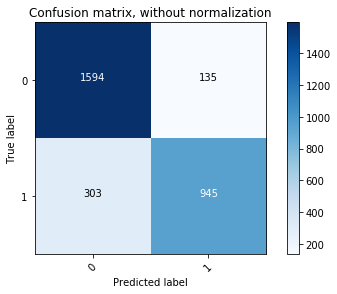

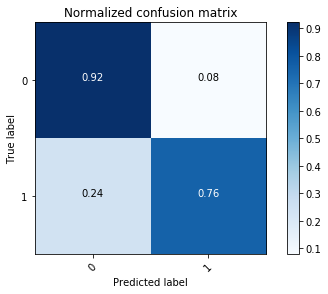

Confusion matrix, without normalization
[[179  14]
 [ 41  98]]
Normalized confusion matrix
[[0.92746114 0.07253886]
 [0.29496403 0.70503597]]


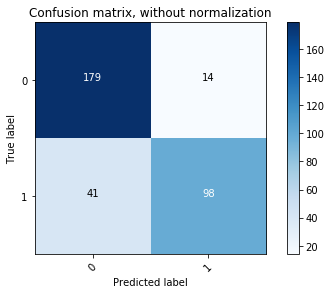

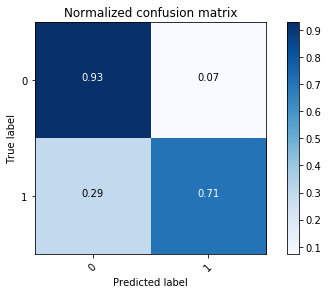

Wall time: 2min 55s


In [28]:
%%time

model_rt_1, history_rt_1, test_scores_rt_1 = run_VGG16_without_retrain_on_dataset(X_rt_train, y_rt_train,
                                                                           X_rt_test, y_rt_test,
                                                                           categories_count=2,
                                                                           patience=5)


In [29]:
print("right_top result accuracy:", test_scores_rt_1[1])

right_top result accuracy: 0.8343373486794621


In [30]:
model_rt = model_rt_1
history_rt = history_rt_1
test_scores_rt = test_scores_rt_1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 16386     
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 16s 5ms/step - loss: 4.2248 - acc: 0.6738 - val_loss: 3.1609 - val_acc: 0.7500
Epoch 2/300
2977/2977 [==============================] - 15s 5ms/step

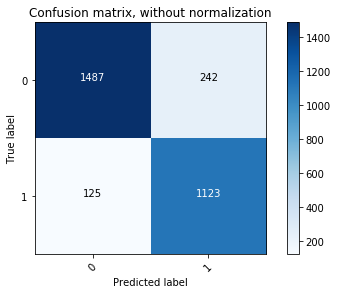

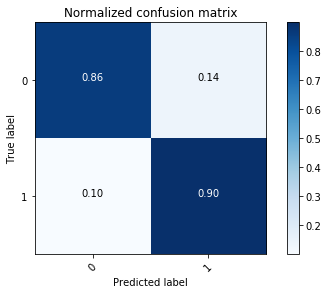

Confusion matrix, without normalization
[[157  36]
 [ 23 116]]
Normalized confusion matrix
[[0.8134715  0.1865285 ]
 [0.16546763 0.83453237]]


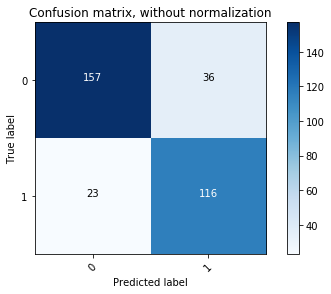

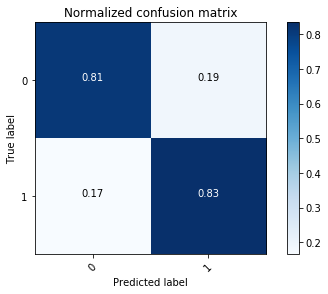

Wall time: 3min 24s


In [31]:
%%time
X_lb_train, y_lb_train, X_lb_test, y_lb_test = divide_to_train_end_test(X_lb_FNML128, y_lb_FNML128, num_categories=2)


model_lb, history_lb, test_scores_lb = run_VGG16_without_retrain_on_dataset(X_lb_train, y_lb_train,
                                                                           X_lb_test, y_lb_test,
                                                                           categories_count=2,
                                                                           patience=5)

In [32]:
print("left_bottom result accuracy:", test_scores_lb[1])

left_bottom result accuracy: 0.822289156626506


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_15 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 16386     
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 16s 5ms/step - loss: 4.0854 - acc: 0.6809 - val_loss: 3.0227 - val_acc: 0.7771
Epoch 2/300
2977/2977 [==============================] - 15s 5ms/step

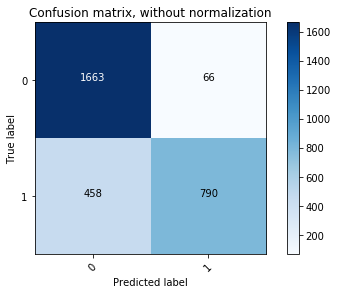

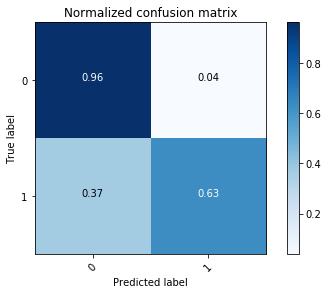

Confusion matrix, without normalization
[[176  17]
 [ 64  75]]
Normalized confusion matrix
[[0.9119171  0.0880829 ]
 [0.46043165 0.53956835]]


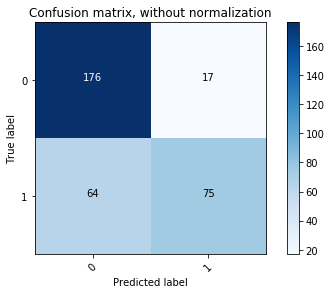

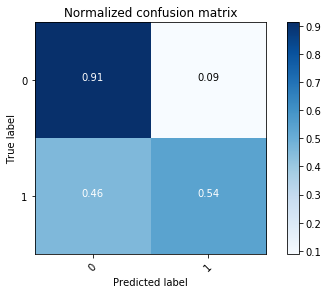

Wall time: 2min 27s


In [36]:
%%time
X_rb_train, y_rb_train, X_rb_test, y_rb_test = divide_to_train_end_test(X_rb_FNML128, y_rb_FNML128, num_categories=2)


model_rb, history_rb, test_scores_rb = run_VGG16_without_retrain_on_dataset(X_rb_train, y_rb_train,
                                                                           X_rb_test, y_rb_test,
                                                                           categories_count=2,
                                                                           patience=5)

In [37]:
print("right_bottom result accuracy:", test_scores_rb[1])

right_bottom result accuracy: 0.7560240967446062


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_16 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 16386     
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 16s 5ms/step - loss: 3.8923 - acc: 0.6977 - val_loss: 2.9371 - val_acc: 0.7771
Epoch 2/300
2977/2977 [==============================] - 15s 5ms/step

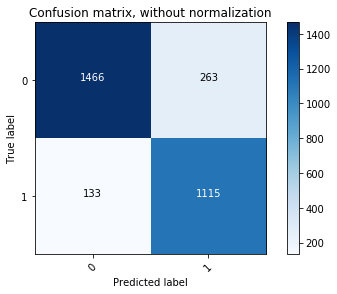

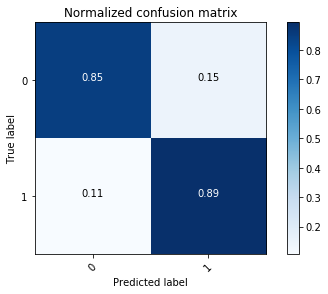

Confusion matrix, without normalization
[[146  47]
 [ 33 106]]
Normalized confusion matrix
[[0.75647668 0.24352332]
 [0.23741007 0.76258993]]


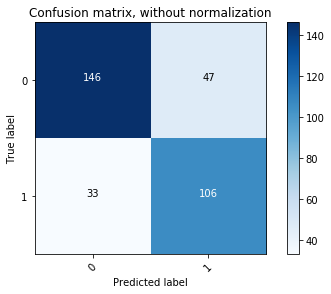

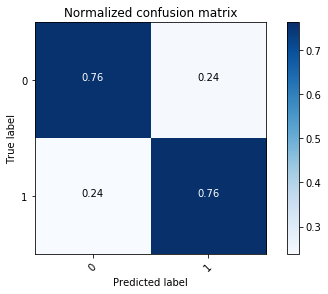

Wall time: 1min 44s


In [38]:
%%time
model_rb_1, history_rb_1, test_scores_rb_1 = run_VGG16_without_retrain_on_dataset(X_rb_train, y_rb_train,
                                                                           X_rb_test, y_rb_test,
                                                                           categories_count=2,
                                                                           patience=5)

In [39]:
print("right_bottom result accuracy:", test_scores_rb_1[1])

right_bottom result accuracy: 0.7590361442192491


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 16386     
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 16s 5ms/step - loss: 4.2410 - acc: 0.6859 - val_loss: 3.5176 - val_acc: 0.7590
Epoch 2/300
2977/2977 [==============================] - 15s 5ms/step

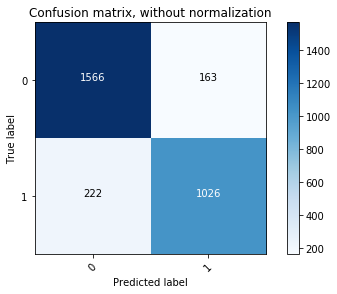

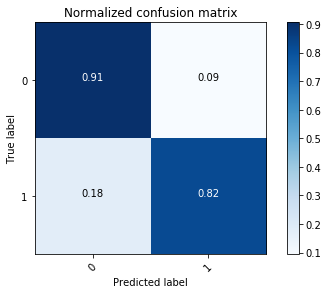

Confusion matrix, without normalization
[[165  28]
 [ 39 100]]
Normalized confusion matrix
[[0.85492228 0.14507772]
 [0.28057554 0.71942446]]


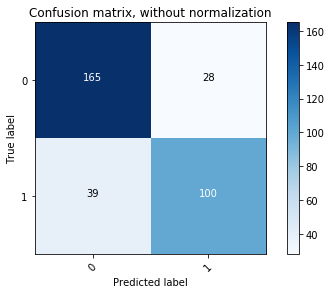

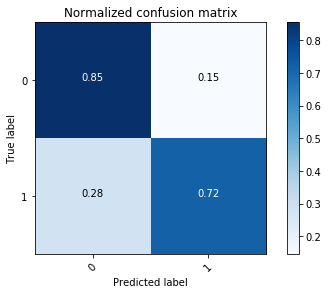

Wall time: 2min 27s


In [40]:
%%time
model_rb_2, history_rb_2, test_scores_rb_2 = run_VGG16_without_retrain_on_dataset(X_rb_train, y_rb_train,
                                                                           X_rb_test, y_rb_test,
                                                                           categories_count=2,
                                                                           patience=5)

In [41]:
print("right_bottom result accuracy:", test_scores_rb_2[1])

right_bottom result accuracy: 0.7981927710843374


In [42]:
model_rb = model_rb_2
history_rb = history_rb_2
test_scores_rb = test_scores_rb_2

## Validation accuracy results

In [43]:
print("center result accuracy: %.4f" % test_scores_ct[1])
print("left_top result accuracy: %.4f" % test_scores_lt[1])
print("right_top result accuracy: %.4f" % test_scores_rt[1])
print("left_bottom result accuracy: %.4f" % test_scores_lb[1])
print("right_bottom result accuracy: %.4f" % test_scores_rb[1])

center result accuracy: 0.8373
left_top result accuracy: 0.8705
right_top result accuracy: 0.8343
left_bottom result accuracy: 0.8223
right_bottom result accuracy: 0.7982


In [44]:
predict_result_ct_train = model_ct.predict(X_ct_train)
predict_result_ct_test = model_ct.predict(X_ct_test)

predict_result_lt_train = model_lt.predict(X_lt_train)
predict_result_lt_test = model_lt.predict(X_lt_test)

predict_result_rt_train = model_lt.predict(X_rt_train)
predict_result_rt_test = model_lt.predict(X_rt_test)

predict_result_lb_train = model_lt.predict(X_lb_train)
predict_result_lb_test = model_lt.predict(X_lb_test)

predict_result_rb_train = model_lt.predict(X_rb_train)
predict_result_rb_test = model_lt.predict(X_rb_test)

In [45]:
predict_un_train = np.concatenate((predict_result_ct_train,
                                  predict_result_lt_train,
                                  predict_result_rt_train,
                                  predict_result_lb_train,
                                  predict_result_rb_train), axis=1)
print(predict_un_train.shape)

(2977, 10)


In [46]:
predict_un_test = np.concatenate((predict_result_ct_test,
                                  predict_result_lt_test,
                                  predict_result_rt_test,
                                  predict_result_lb_test,
                                  predict_result_rb_test), axis=1)
print(predict_un_test.shape)

(332, 10)


In [47]:
# than write this arrays into file
file_path_un_train = "./un_train_France_ByMeaningLarge128.npy"
np.save(file_path_un_train, predict_un_train)

file_path_un_test = "./un_test_France_ByMeaningLarge128.npy"
np.save(file_path_un_test, predict_un_test)

file_path_y_train = "./y_train_France_ByMeaningLarge128.npy"
np.save(file_path_y_train, y_ct_train)

file_path_y_test = "./y_test_France_ByMeaningLarge128.npy"
np.save(file_path_y_test, y_ct_test)

In [33]:
#np.load(file_path_un_train)

test accuracy:  0.8886

Confusion matrix, without normalization
[[1631   98]
 [ 140 1108]]
Normalized confusion matrix
[[0.94331984 0.05668016]
 [0.11217949 0.88782051]]


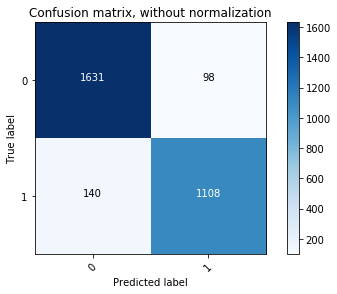

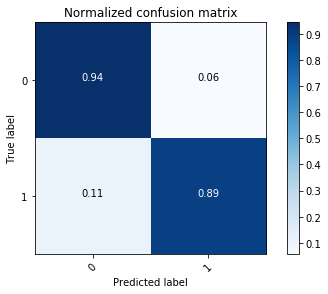

Confusion matrix, without normalization
[[180  13]
 [ 24 115]]
Normalized confusion matrix
[[0.93264249 0.06735751]
 [0.17266187 0.82733813]]


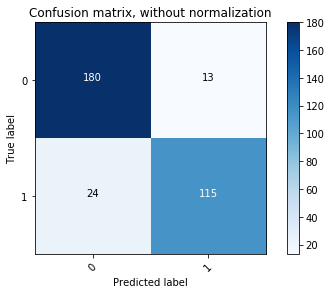

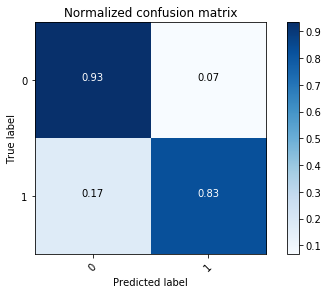

In [48]:
#let's try KNN first
categories_count = 2

knn_uniform_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='uniform')
knn_uniform_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_uniform_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_uniform_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_uniform_15)
print("")

print_confusion_matrix(knn_uniform_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

In [35]:
# write predicted result into file

In [49]:
knn_uniform_15_predict_train = knn_uniform_15.predict(predict_un_train)
knn_uniform_15_predict_test = knn_uniform_15.predict(predict_un_test)

file_path_knn_uniform_15_train = "./knn_uniform_15_train_France_ByMeaningLarge128.npy"
np.save(file_path_knn_uniform_15_train, knn_uniform_15_predict_train)

file_path_knn_uniform_15_test = "./knn_uniform_15_test_France_ByMeaningLarge128.npy"
np.save(file_path_knn_uniform_15_test, knn_uniform_15_predict_test)


test accuracy:  0.8976

Confusion matrix, without normalization
[[1729    0]
 [   8 1240]]
Normalized confusion matrix
[[1.         0.        ]
 [0.00641026 0.99358974]]


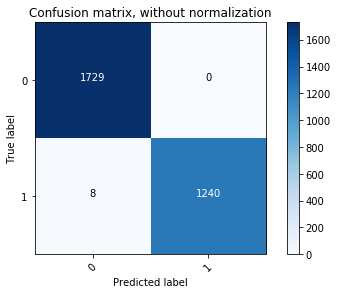

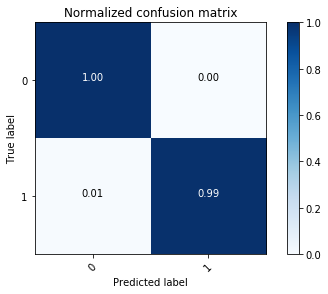

Confusion matrix, without normalization
[[180  13]
 [ 21 118]]
Normalized confusion matrix
[[0.93264249 0.06735751]
 [0.15107914 0.84892086]]


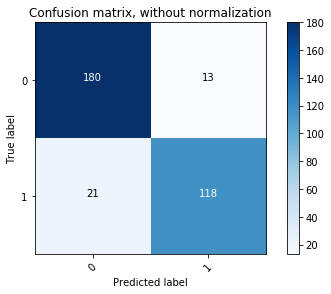

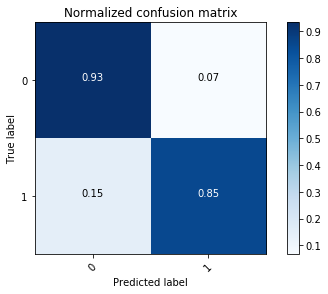

In [50]:
#let's try KNN with another weights
knn_distance_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_distance_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_distance_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_distance_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_distance_15)
print("")

print_confusion_matrix(knn_distance_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

In [51]:
knn_distance_15_predict_train = knn_distance_15.predict(predict_un_train)
knn_distance_15_predict_test = knn_distance_15.predict(predict_un_test)

file_path_knn_distance_15_train = "./knn_distance_15_train_France_ByMeaningLarge128.npy"
np.save(file_path_knn_distance_15_train, knn_distance_15_predict_train)

file_path_knn_distance_15_test = "./knn_distance_15_test_France_ByMeaningLarge128.npy"
np.save(file_path_knn_distance_15_test, knn_distance_15_predict_test)


In [52]:
# than SVM
svm = SVC(kernel='rbf')
svm.fit(predict_un_train, y_ct_train)

acc_svm = accuracy_score(y_ct_test, svm.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_svm)
print("")

#print_confusion_matrix(svm, predict_un_train, y_ct_train, 
#                       predict_un_test, y_ct_test, categories_count=categories_count)

test accuracy:  0.8434



In [53]:
svm_predict_train = svm.predict(predict_un_train)
svm_predict_test = svm.predict(predict_un_test)

file_path_svm_train = "./svm_train_France_ByMeaningLarge128.npy"
np.save(file_path_svm_train, svm_predict_train)

file_path_svm_test = "./svm_test_France_ByMeaningLarge128.npy"
np.save(file_path_svm_test, svm_predict_test)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               5632      
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 514       
Total params: 137,474
Trainable params: 137,474
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 9s 3ms/step - loss: 0.2814 

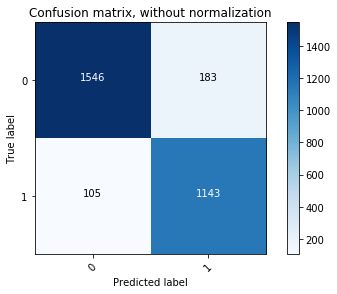

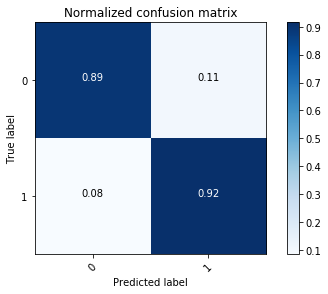

Confusion matrix, without normalization
[[161  32]
 [ 14 125]]
Normalized confusion matrix
[[0.83419689 0.16580311]
 [0.10071942 0.89928058]]


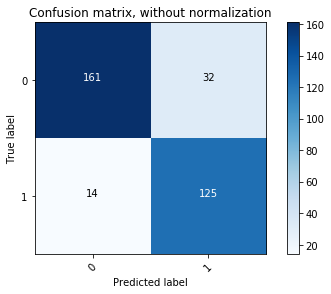

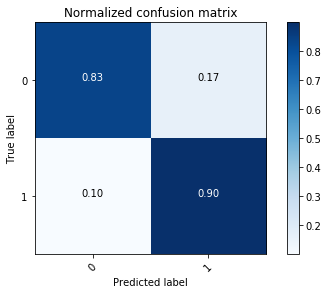

Wall time: 1min 34s


In [54]:
%%time
# and also multilayer neuron net
categories_count = 2

meta_net = Sequential()
meta_net.add(Dense(512, input_shape=predict_un_train[0].shape))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(256))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(categories_count, activation='softmax'))
meta_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(meta_net.summary())
    
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history_callback = meta_net.fit(predict_un_train, one_hot(y_ct_train, categories_count), 
                            validation_data=(predict_un_test, one_hot(y_ct_test, categories_count)),
                            epochs=300, batch_size=10, callbacks=[callback])

test_scores = meta_net.evaluate(predict_un_test, one_hot(y_ct_test, categories_count), verbose=0)
    
print_confusion_matrix(meta_net, predict_un_train, y_ct_train, predict_un_test, y_ct_test, categories_count)

In [55]:
print("test accuracy:  %.4f" % test_scores[1])
print("best test accuracy: %.4f" % max(history_callback.history['val_acc']))

test accuracy:  0.8614
best test accuracy: 0.9006


In [56]:
meta_net_predict_train = meta_net.predict(predict_un_train)
meta_net_predict_test = meta_net.predict(predict_un_test)

file_path_meta_net_train = "./meta_net_train_France_ByMeaningLarge128.npy"
np.save(file_path_meta_net_train, meta_net_predict_train)

file_path_meta_net_test = "./meta_net_test_France_ByMeaningLarge128.npy"
np.save(file_path_meta_net_test, meta_net_predict_test)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 512)               5632      
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 514       
Total params: 137,474
Trainable params: 137,474
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 9s 3ms/step - loss: 0.2772 

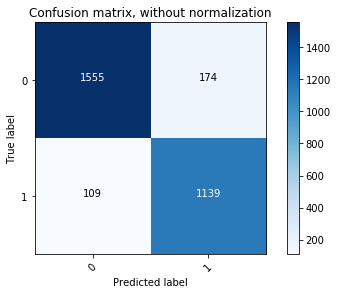

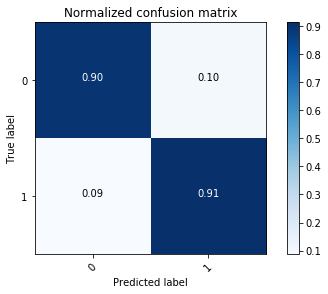

Confusion matrix, without normalization
[[162  31]
 [ 16 123]]
Normalized confusion matrix
[[0.83937824 0.16062176]
 [0.11510791 0.88489209]]


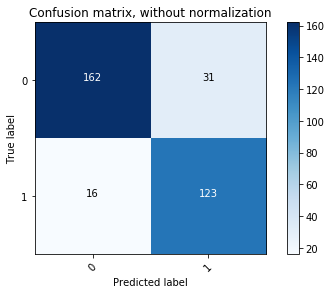

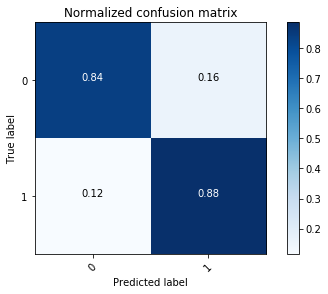

Wall time: 1min 14s


In [59]:
%%time
# and also multilayer neuron net
categories_count = 2

meta_net = Sequential()
meta_net.add(Dense(512, input_shape=predict_un_train[0].shape))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(256))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(categories_count, activation='softmax'))
meta_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(meta_net.summary())
    
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history_callback = meta_net.fit(predict_un_train, one_hot(y_ct_train, categories_count), 
                            validation_data=(predict_un_test, one_hot(y_ct_test, categories_count)),
                            epochs=300, batch_size=10, callbacks=[callback])

test_scores = meta_net.evaluate(predict_un_test, one_hot(y_ct_test, categories_count), verbose=0)
    
print_confusion_matrix(meta_net, predict_un_train, y_ct_train, predict_un_test, y_ct_test, categories_count)